# Tutorial machine learning NEB algorithm (ML-NEB).

This tutorial is meant to be used to familiarized yourself with the machine learning algorithm ML-NEB.

## 0. Important notes:

When running ML-NEB, the user must feed a calculator to the "MLNEB" class.
This calculator must contain the same flags as when performing a single-point calculation.

For instance, when using the Vasp calculator one must set:

    istart=0, nsw=0 and ibrion=-1

or when using Quantum Espresso one must set:

    calculation='scf' 

## 1. How to run ML-NEB.

For this example we will build the Atoms structures for the initial and final end-points of our NEB calculation.

First, we will start by setting up an ASE calculator. In this case, we will use the EMT() potential as implemented in ASE:

In [75]:
from ase.calculators.emt import EMT

ase_calculator = EMT()

We will create a 2$\times$2-Al(100) slab in which we will add an Al adatom on top of the surface:

In [76]:
from ase.build import fcc100, add_adsorbate
from ase.constraints import FixAtoms


# 2x2-Al(001) surface with 3 layers and an
# Au atom adsorbed in a hollow site:
slab = fcc100('Al', size=(2, 2, 3))
add_adsorbate(slab, 'Au', 1.7, 'hollow')
slab.center(axis=2, vacuum=4.0)

# Fix second and third layers:
mask = [atom.tag > 1 for atom in slab]
slab.set_constraint(FixAtoms(mask=mask))

Then, we will append the ASE calculator to the Atoms object:

In [77]:
slab.set_calculator(ase_calculator)

And we will carry out the optimization of the initial and final end-points:

In [78]:
from ase.optimize import BFGS

# Initial end-point:
qn = BFGS(slab, trajectory='initial.traj')
qn.run(fmax=0.01)

# Final end-point:
slab[-1].x += slab.get_cell()[0, 0] / 2
qn = BFGS(slab, trajectory='final.traj')
qn.run(fmax=0.01)

      Step     Time          Energy         fmax
BFGS:    0 19:00:48        3.323870        0.2462
BFGS:    1 19:00:48        3.321365        0.2035
BFGS:    2 19:00:48        3.314740        0.0206
BFGS:    3 19:00:48        3.314706        0.0298
BFGS:    4 19:00:48        3.314668        0.0352
BFGS:    5 19:00:48        3.314574        0.0398
BFGS:    6 19:00:48        3.314451        0.0342
BFGS:    7 19:00:48        3.314351        0.0168
BFGS:    8 19:00:48        3.314318        0.0087
      Step     Time          Energy         fmax
BFGS:    0 19:00:48        3.323351        0.1583
BFGS:    1 19:00:48        3.321730        0.1417
BFGS:    2 19:00:48        3.315785        0.0652
BFGS:    3 19:00:48        3.315584        0.0694
BFGS:    4 19:00:48        3.314652        0.0600
BFGS:    5 19:00:48        3.314389        0.0332
BFGS:    6 19:00:48        3.314326        0.0124
BFGS:    7 19:00:48        3.314319        0.0090


True

The trajectory files containing the optimized structures ("initial.traj" and "final.traj") will be used in our ML-NEB calculation as the starting positions for the NEB.

You can select the number of images for the ML-NEB as an integer (e.g. 11 images) or alternately, you can automatically select the number of initial images deciding the spacing between them (in Angstrom). This is done by introducing a float (e.g. 0.2) in "n_images".
Running ML-NEB might take a few seconds...

In [87]:
from catlearn.optimize.mlneb import MLNEB

neb_catlearn = MLNEB(start='initial.traj', # Initial end-point.
                     end='final.traj', # Final end-point.
                     ase_calc=ase_calculator, # Calculator, it must be the same as the one used for the optimizations.
                     n_images=7, # Number of images (interger or float, see above).
                     interpolation='idpp', # Choose between linear or idpp interpolation (as implemented in ASE).
                     restart=False)
neb_catlearn.run(fmax=0.05, trajectory='ML-NEB.traj')

 
       ____      _   _                          
      / ___|__ _| |_| |    ___  __ _ _ __ _ __  
     | |   / _` | __| |   / _ \/ _` | '__| '_ \ 
     | |__| (_| | |_| |__|  __/ (_| | |  | | | |
      \____\__,_|\__|_____\___|\__,_|_|  |_| |_| NEB v.1.0.0
      
      
Training a GP process...
Number of training points: 3
Optimized hyperparameters:       fun: array([52.78378344])
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 7.49673390e+00, -2.60769184e-04,  8.59934346e-02,  1.25695010e-03,
        7.10542736e-07])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 84
      nit: 12
   status: 0
  success: True
        x: array([1.00000000e+00, 1.02642149e+00, 1.00000000e-03, 1.00000000e-04,
       0.00000000e+00])
GP process trained.
Max number steps: 250
Using initial path.
Optimizing ML CI-NEB using dt: 0.025
       Step     Time          Energy         fmax
MDMin:    0 21:52:04        4.290590        2.9152
MDMin:    1 21:52:04  

MDMin:   21 21:52:08        3.694756        0.4660
MDMin:   22 21:52:08        3.687435        0.3601
MDMin:   23 21:52:08        3.683028        0.2740
MDMin:   24 21:52:08        3.680928        0.2065
MDMin:   25 21:52:08        3.680498        0.1511
MDMin:   26 21:52:08        3.681069        0.1214
MDMin:   27 21:52:08        3.681958        0.0911
MDMin:   28 21:52:08        3.682564        0.0595
MDMin:   29 21:52:08        3.682698        0.0392
ML CI-NEB converged.
Number of images: 7
Length of initial path (Angstrom): 2.864384697861581
Length of the current path (Angstrom): 3.1014876792598436
Spring constant (eV/Angstrom): 1.447304634224494
Acquisition function: acq_2
Uncertainty convergence set by user (eV): 0.05
Max. uncertainty (eV): 0.24903750267358857
Image #id with max. uncertainty: 5
Number of iterations: 4
Max. force of the last image evaluated (eV/Angstrom): 1.206779303205325
Energy of the last image evaluated (eV): 3.772931718478988
Forward reaction barrier energy 

MDMin:   16 21:52:12        3.715308        0.3528
MDMin:   17 21:52:12        3.708518        0.2509
MDMin:   18 21:52:12        3.703440        0.1795
MDMin:   19 21:52:12        3.699148        0.1268
MDMin:   20 21:52:12        3.695656        0.0903
MDMin:   21 21:52:12        3.693084        0.0602
MDMin:   22 21:52:12        3.691523        0.0381
ML CI-NEB converged.
Number of images: 7
Length of initial path (Angstrom): 2.864384697861581
Length of the current path (Angstrom): 3.0085063958172964
Spring constant (eV/Angstrom): 1.447304634224494
Acquisition function: acq_2
Uncertainty convergence set by user (eV): 0.05
Max. uncertainty (eV): 0.12308570745076229
Image #id with max. uncertainty: 6
Number of iterations: 7
Max. force of the last image evaluated (eV/Angstrom): 0.443593591481629
Energy of the last image evaluated (eV): 3.4575685217375574
Forward reaction barrier energy (eV): 0.1432506253299355
Backward reaction barrier energy (eV): 0.1432492848325264
Number #id of the 

Optimized hyperparameters:       fun: array([119.84239403])
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.44668519e+01, -1.87867499e-03, -5.52628160e+02, -1.61679452e+00,
        0.00000000e+00])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 96
      nit: 12
   status: 0
  success: True
        x: array([1.       , 0.7241026, 0.01     , 0.001    , 0.       ])
GP process trained.
Max number steps: 250
Using initial path.
Optimizing ML CI-NEB using dt: 0.025
       Step     Time          Energy         fmax
MDMin:    0 21:52:15        4.238972        3.2286
MDMin:    1 21:52:15        4.232894        3.2094
MDMin:    2 21:52:15        4.214957        3.1519
MDMin:    3 21:52:15        4.186043        3.0570
MDMin:    4 21:52:15        4.147583        2.9261
MDMin:    5 21:52:15        4.101483        2.7615
MDMin:    6 21:52:15        4.050019        2.5662
MDMin:    7 21:52:16        3.995704        2.3441
MDMin:    8 21:52:16   

Congratulations, your ML-NEB is converged. Now we will proceed to analyze the output of this run...

## 2. Plot ML-NEB results.


In order to plot the predicted path we can use the results stored in the files "results_neb.csv" and "results_neb_interpolation.csv". These files contains the position of the images with respect to the length of the band and their corresponding energies and uncertainties.

To plot the converged path one can use our tool "plotneb" as:

Energy barrier: 0.3753396358791905 eV
Saving pdf file with the NEB profile in file: MLNEB.pdf


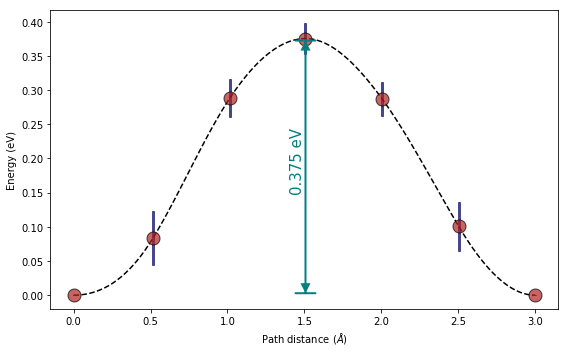

Visualizing NEB images in ASE...


In [80]:
from catlearn.optimize.tools import plotneb
plotneb(trajectory='ML-NEB.traj')

## 3. Restarting ML-NEB.

Restarting a NEB calculation is not a tedious process anymore (WOOHOO!). 
Let's imagine that our ML-NEB has not converged. This is common ocurrence when using computer clusters and computationally demanding calculations. In this example, the calculation will not converged because the number of iterations will exceed the maximum number of steps.

In [81]:
neb_catlearn = MLNEB(start='initial.traj', # Initial end-point.
                     end='final.traj', # Final end-point.
                     ase_calc=ase_calculator, # Calculator, it must be the same as the one used for the optimizations.
                     n_images=7, # Number of images (interger or float, see above).
                     interpolation='idpp', # Choose between linear or idpp interpolation (as implemented in ASE).
                    )
neb_catlearn.run(fmax=0.05, trajectory='ML-NEB.traj', steps=5)

 
       ____      _   _                          
      / ___|__ _| |_| |    ___  __ _ _ __ _ __  
     | |   / _` | __| |   / _ \/ _` | '__| '_ \ 
     | |__| (_| | |_| |__|  __/ (_| | |  | | | |
      \____\__,_|\__|_____\___|\__,_|_|  |_| |_| NEB v.1.0.0
      
      
Training a GP process...
Number of training points: 3
Optimized hyperparameters:       fun: array([52.78378344])
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 7.49673390e+00, -2.60769184e-04,  8.59934346e-02,  1.25695010e-03,
        7.10542736e-07])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 84
      nit: 12
   status: 0
  success: True
        x: array([1.00000000e+00, 1.02642149e+00, 1.00000000e-03, 1.00000000e-04,
       0.00000000e+00])
GP process trained.
Max number steps: 250
Using initial path.
Optimizing ML CI-NEB using dt: 0.025
       Step     Time          Energy         fmax
MDMin:    0 19:01:02        4.290590        2.9152
MDMin:    1 19:01:02  

MDMin:   21 19:01:06        3.694756        0.4660
MDMin:   22 19:01:06        3.687435        0.3601
MDMin:   23 19:01:06        3.683028        0.2740
MDMin:   24 19:01:06        3.680928        0.2065
MDMin:   25 19:01:06        3.680498        0.1511
MDMin:   26 19:01:06        3.681069        0.1214
MDMin:   27 19:01:07        3.681958        0.0911
MDMin:   28 19:01:07        3.682564        0.0595
MDMin:   29 19:01:07        3.682698        0.0392
ML CI-NEB converged.
Number of images: 7
Length of initial path (Angstrom): 2.864384697861581
Length of the current path (Angstrom): 3.1014876792598436
Spring constant (eV/Angstrom): 1.447304634224494
Acquisition function: acq_2
Uncertainty convergence set by user (eV): 0.05
Max. uncertainty (eV): 0.24903750267358857
Image #id with max. uncertainty: 5
Number of iterations: 4
Max. force of the last image evaluated (eV/Angstrom): 1.206779303205325
Energy of the last image evaluated (eV): 3.772931718478988
Forward reaction barrier energy 

When using ML-NEB the most important file is the "evaluated_structures.traj" file. 
This file contains all the Atoms structures evaluated in each iteration.
In order to restart the ML-NEB calculation from the last iteration make sure you run the calculation in the same folder than the one containing the "evaluated_structures.traj".
Then, select "restart=True" in the MLNEB class:        

In [82]:
neb_catlearn = MLNEB(start='initial.traj', # Initial end-point.
                     end='final.traj', # Final end-point.
                     ase_calc=ase_calculator, # Calculator, it must be the same as the one used for the optimizations.
                     n_images=7, # Number of images (interger or float, see above).
                     interpolation='idpp', # Choose between linear or idpp interpolation (as implemented in ASE).
                     restart=True)
neb_catlearn.run(fmax=0.05, trajectory='ML-NEB.traj')

 
       ____      _   _                          
      / ___|__ _| |_| |    ___  __ _ _ __ _ __  
     | |   / _` | __| |   / _ \/ _` | '__| '_ \ 
     | |__| (_| | |_| |__|  __/ (_| | |  | | | |
      \____\__,_|\__|_____\___|\__,_|_|  |_| |_| NEB v.1.0.0
      
      
Training a GP process...
Number of training points: 6
Optimized hyperparameters:       fun: array([91.80337257])
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 5.16076568e+00, -3.69482223e-05, -1.39100734e+01, -1.08092024e+00,
        0.00000000e+00])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 60
      nit: 8
   status: 0
  success: True
        x: array([1.        , 0.94571386, 0.01      , 0.001     , 0.        ])
GP process trained.
Max number steps: 250
Using initial path.
Optimizing ML CI-NEB using dt: 0.025
       Step     Time          Energy         fmax
MDMin:    0 19:01:08        3.763354        0.7614
MDMin:    1 19:01:09        3.762950        0.7601

MDMin:   28 19:01:13        3.673984        0.0775
MDMin:   29 19:01:13        3.673136        0.0789
MDMin:   30 19:01:13        3.672508        0.0788
MDMin:   31 19:01:13        3.672066        0.0773
MDMin:   32 19:01:13        3.671810        0.0745
MDMin:   33 19:01:13        3.671762        0.0705
MDMin:   34 19:01:13        3.671958        0.0654
MDMin:   35 19:01:13        3.672438        0.0592
MDMin:   36 19:01:13        3.673225        0.0616
MDMin:   37 19:01:13        3.674294        0.0657
MDMin:   38 19:01:13        3.675519        0.0681
MDMin:   39 19:01:13        3.676650        0.0675
MDMin:   40 19:01:13        3.677389        0.0629
MDMin:   41 19:01:13        3.677526        0.0539
MDMin:   42 19:01:14        3.677062        0.0417
ML CI-NEB converged.
Number of images: 7
Length of initial path (Angstrom): 2.864384697861581
Length of the current path (Angstrom): 3.372044601520657
Spring constant (eV/Angstrom): 1.447304634224494
Acquisition function: acq_2
Uncerta

MDMin:    8 19:01:17        3.952222        1.5872
MDMin:    9 19:01:17        3.923534        1.4782
MDMin:   10 19:01:17        3.894533        1.3596
MDMin:   11 19:01:17        3.866011        1.2329
MDMin:   12 19:01:17        3.838721        1.0995
MDMin:   13 19:01:17        3.813338        0.9611
MDMin:   14 19:01:17        3.790421        0.8199
MDMin:   15 19:01:17        3.770366        0.6784
MDMin:   16 19:01:17        3.753354        0.5399
MDMin:   17 19:01:17        3.739298        0.4094
MDMin:   18 19:01:17        3.727816        0.2941
MDMin:   19 19:01:18        3.718320        0.2139
MDMin:   20 19:01:18        3.710268        0.1983
MDMin:   21 19:01:18        3.703330        0.1823
MDMin:   22 19:01:18        3.697364        0.1641
MDMin:   23 19:01:18        3.692298        0.1448
MDMin:   24 19:01:18        3.688060        0.1250
MDMin:   25 19:01:18        3.684571        0.1051
MDMin:   26 19:01:18        3.681745        0.0893
MDMin:   27 19:01:18        3.6

We can also change the number of images, increase the convergence criteria and re-run (restart) the calculation.

In [83]:
neb_catlearn = MLNEB(start='initial.traj', # Initial end-point.
                     end='final.traj', # Final end-point.
                     ase_calc=ase_calculator, # Calculator, it must be the same as the one used for the optimizations.
                     n_images=21, # Number of images (interger or float, see above).
                     interpolation='idpp', # Choose between linear or idpp interpolation (as implemented in ASE).
                     restart=True)
neb_catlearn.run(fmax=0.02, unc_convergence=0.025, trajectory='ML-NEB.traj')


 
       ____      _   _                          
      / ___|__ _| |_| |    ___  __ _ _ __ _ __  
     | |   / _` | __| |   / _ \/ _` | '__| '_ \ 
     | |__| (_| | |_| |__|  __/ (_| | |  | | | |
      \____\__,_|\__|_____\___|\__,_|_|  |_| |_| NEB v.1.0.0
      
      
Training a GP process...
Number of training points: 15
Optimized hyperparameters:       fun: array([-80.30765379])
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([4.20290917e+01, 1.57858949e+01, 1.99085820e+03, 1.49998719e+05,
       0.00000000e+00])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 126
      nit: 7
   status: 0
  success: True
        x: array([1.00000000e+00, 8.06375977e-01, 1.00000000e-03, 1.00000000e-04,
       0.00000000e+00])
GP process trained.
Max number steps: 315
Using initial path.
Optimizing ML CI-NEB using dt: 0.025
       Step     Time          Energy         fmax
MDMin:    0 19:01:22        4.119674        2.4900
MDMin:    1 19:01:22     

Optimized hyperparameters:       fun: array([-93.69166803])
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.90835863e+00, -1.21114226e+01, -3.80806932e+02,  1.49990172e+05,
        0.00000000e+00])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 114
      nit: 6
   status: 0
  success: True
        x: array([1.00000000e+00, 8.32762309e-01, 1.00000000e-02, 1.00000000e-04,
       0.00000000e+00])
GP process trained.
Max number steps: 315
Using initial path.
Optimizing ML CI-NEB using dt: 0.025
       Step     Time          Energy         fmax
MDMin:    0 19:01:40        4.129871        2.5195
MDMin:    1 19:01:40        4.126182        2.5082
MDMin:    2 19:01:40        4.115252        2.4743
MDMin:    3 19:01:40        4.097492        2.4184
MDMin:    4 19:01:41        4.073578        2.3410
MDMin:    5 19:01:41        4.044417        2.2432
MDMin:    6 19:01:41        4.011114        2.1263
MDMin:    7 19:01:41        3.974919      

Optimized hyperparameters:       fun: array([-211.51194233])
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([2.86603722e+01, 6.57337296e-01, 2.59626801e+03, 1.49958783e+05,
       0.00000000e+00])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 144
      nit: 13
   status: 0
  success: True
        x: array([1.00000000e+00, 8.10803504e-01, 1.00000000e-03, 1.00000000e-04,
       0.00000000e+00])
GP process trained.
Congratulations! Your ML NEB is converged. Check the file  'last_predicted_path.traj' using ASE. If you want to plot the ML NEB predicted path you should also check the files 'results_neb.csv' and 'results_neb_interpolation.csv'.
The optimized predicted path can be found in:  ML-NEB.traj
Number of steps performed in this run: 5


Energy barrier: 0.37412900111500935 eV
Saving pdf file with the NEB profile in file: MLNEB.pdf


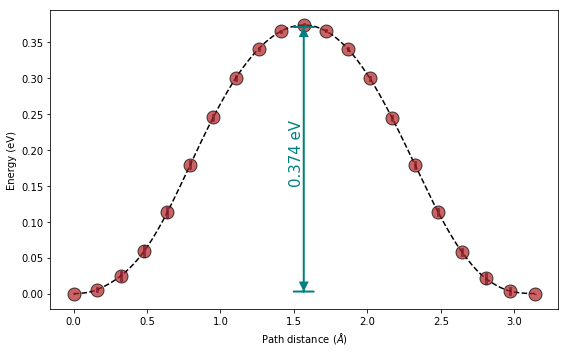

Visualizing NEB images in ASE...


In [84]:
plotneb(trajectory='ML-NEB.traj')